-----> Before text cleaning  

Dataset columns: 
 	 Index(['Course Name', 'University', 'Difficulty_Level', 'Course Rating',
       'Course URL', 'Course Description', 'Skills'],
      dtype='object') 

Dataset dimensions (rows, columns) : 
 	 (3532, 7) 

Unique classes: 
 	 ['Beginner' 'Advanced' 'Intermediate' 'Not Calibrated' 'Conversant'
 'Goldman Sachs' nan] 

-----> After text cleaning  

Dataset columns: 
 	 Index(['Course_Name', 'University', 'Difficulty_Level', 'Course_Description',
       'Skills', 'category_id'],
      dtype='object') 

Dataset dimensions (rows, columns) : 
 	 (2928, 6) 

Unique classes: 
 	 ['Beginner' 'Advanced' 'Intermediate'] 

CLASS BALANCE


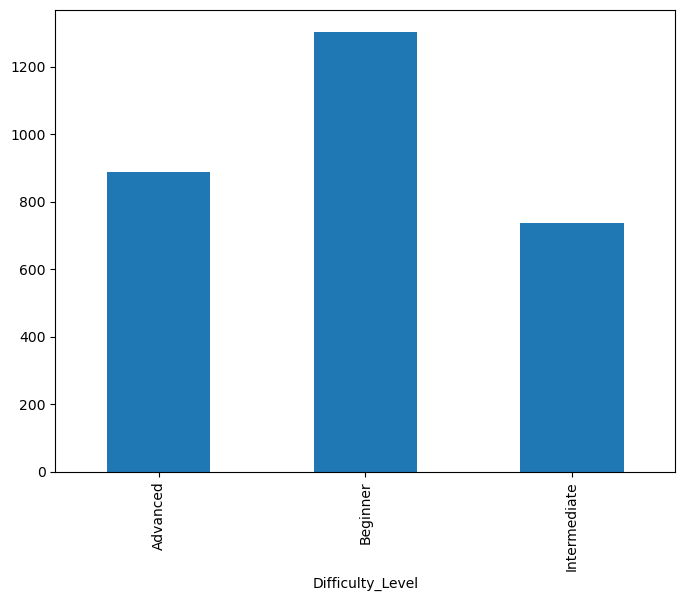

Class Imbalance Summary:
                     Class  Count  Percentage
Beginner          Beginner   1303   44.501366
Advanced          Advanced    887   30.293716
Intermediate  Intermediate    738   25.204918


In [1]:
# @@@@@@@@@@@@@@@@@@@       DATA PREPROCESSING      @@@@@@@@@@@@@@@@@@@
# @@@@@@@@@@@@@@@@@@@       SPLITTING      @@@@@@@@@@@@@@@@@@@
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re

import warnings
import sys, os

# # # # https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
# # # if not sys.warnoptions:
# # #     warnings.simplefilter("ignore")
# # #     os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses


# https://towardsdatascience.com/how-to-split-a-dataframe-into-train-and-test-set-with-python-eaa1630ca7b3

# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f


# Read the CSV file into a DataFrame
coursera = pd.read_csv(
    "Coursera_original_university_name_fixed.csv", sep=";", encoding="latin-1"
)
# mudei para latin-1 porque com e sem utf-8 estava dando erro de "UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe0 in position 9: invalid continuation byte"

# print(coursera.head())


def showDatasetCharacteristics(coursera, tittle):
    print(tittle, " \n")

    print(
        "Dataset columns: \n",
        "\t",
        coursera.columns,
        "\n",
    )
    # Display the initial dimensions of the dataset
    print(
        "Dataset dimensions (rows, columns) : \n",
        "\t",
        coursera.shape,
        "\n",
    )

    # Retrieve the unique classes in the "Difficulty_Level" column
    unique_classes = coursera["Difficulty_Level"].unique()
    print(
        "Unique classes: \n",
        "\t",
        unique_classes,
        "\n",
    )


showDatasetCharacteristics(coursera, "-----> Before text cleaning")


# @@@@@@@@@@@@@@@@@@@@@@@@@@ explicar o motivo pelo qual não mantive a classe conversant (é uma classe muito subrepresentada) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Define the undesired classes to be removed
# undesired_classes = ["Goldman Sachs", "Not Calibrated"]
undesired_classes = ["Conversant", "Goldman Sachs", "Not Calibrated"]
# Remove rows with undesired classes in the "Difficulty_Level" column
coursera = coursera[~coursera["Difficulty_Level"].isin(undesired_classes)]

# Select the desired columns in the specified order
col = ["Course Name", "University", "Difficulty_Level", "Course Description", "Skills"]
coursera = coursera[col]


# Rename the columns for clarity
coursera.columns = [
    "Course_Name",
    "University",
    "Difficulty_Level",
    "Course_Description",
    "Skills",
]


def removeRowsWithMissingValues(coursera):
    collumns = [
        "Course_Name",
        "University",
        "Difficulty_Level",
        "Course_Description",
        "Skills",
    ]
    coursera_cleaned = coursera
    for column in collumns:
        # Remove rows with missing values in the "Difficulty_Level" column
        coursera = coursera[pd.notnull(coursera[column])]

        # Remove rows with missing values in the "Skills" column
        coursera = coursera[pd.notnull(coursera[column])]

        # Remove rows with boolean values in the "Skills" column
        coursera = coursera[coursera[column].astype(bool)]
        coursera_cleaned = coursera

    return coursera_cleaned


# Remove rows with missing values
coursera = removeRowsWithMissingValues(coursera)

""" # Convert "Course_Name" column to lowercase
coursera["Course_Name"] = coursera["Course_Name"].str.lower()
# Convert "University" column to lowercase
coursera["University"] = coursera["University"].str.lower()
# Convert "Course_Description" column to lowercase
# coursera["Course_Description"] = coursera["Skills"].str.lower()
# @@@@@@@@@@@@@@@@@@@@@@ HAVIA COMETIDO UM ERRO E ATRIBUIDO OS VALORES DE SKILLS EM COURSE DESCRIPTION, ISSO FEZ COM QUE EU TUNASSE OS MODELOS TODOS COM COURSE_DESCRIPTION COM OS MESMOS VALORES DE SKILLS, OU SEJA, DUPLIQUEI AS COLUNAS. CORRIGIDO AGORA 08062023 AS 1134 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
coursera["Course_Description"] = coursera["Course_Description"].str.lower()
# Convert "Skills" column to lowercase
coursera["Skills"] = coursera["Skills"].str.lower() """


# Remove punctuation and special characters
def remove_special_characters(text):
    # @@@@@@@@@@@@@@@@@@@@@@@@@ First version disabled because tfdifVectorizer with strip_accents="unicode" fix most of the problems found. @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # Use regular expressions to remove punctuation and special characters EXCEPT by the + character used in c++ Skills column.
    # EXCEPT the - character as used in "2-hour long project-based"
    # clean_text = re.sub(r"[^\w\s+-]", "", text)

    # Use regular expressions to remove special character
    # new version, to just take off the " character, as the Course_Descriptions and some Universities have their text surrounded by "".
    clean_text = re.sub(r'"', "", text)
    return clean_text


# Remove special character "
coursera["Course_Name"] = coursera["Course_Name"].apply(remove_special_characters)
coursera["University"] = coursera["University"].apply(remove_special_characters)
coursera["Course_Description"] = coursera["Course_Description"].apply(
    remove_special_characters
)
coursera["Skills"] = coursera["Skills"].apply(remove_special_characters)


def remove_numeric_columns(data):
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data = data.drop(columns=numeric_columns, axis=1)
    return data


# Remove columns with just numbers as values
coursera = remove_numeric_columns(coursera)

""" # DISABLED THIS FUNCTION BECAUSE IT HAS A SIDE EFFECT OF REMOVE SAMPLES AS SKILLS "Industry 4.0"
# # # Remove numeric samples
# # def remove_numeric_samples(text):
# #     # Use regular expressions to check if the text contains numeric values
# #     if re.search(r"\d", text):
# #         return np.nan  # Replace numeric samples with NaN
# #     else:
# #         return text

# # # Remove numeric samples from the "Skills" column
# # coursera["Skills"] = coursera["Skills"].apply(remove_numeric_samples) """

# Remove rows with missing values again because of previous data cleaning genereted NaN "Skills" column samples
# coursera = removeRowsWithMissingValues(coursera)

# Create a new column "category_id" and assign unique numeric values based on the "Difficulty_Level" column
coursera["category_id"] = coursera["Difficulty_Level"].factorize()[0]

# Remove rows with missing values
coursera = removeRowsWithMissingValues(coursera)


showDatasetCharacteristics(coursera, "-----> After text cleaning")

# print(coursera.head())


def plotClassBalanceGraph(coursera):
    # Display the head of the cleaned dataset
    # print(coursera.head())
    print("CLASS BALANCE")
    # Plot a bar chart showing the count of skills per difficulty level
    fig = plt.figure(figsize=(8, 6))
    coursera.groupby("Difficulty_Level").Skills.count().plot.bar(ylim=0)
    plt.show()


plotClassBalanceGraph(coursera)


def calculateClassBalanceStatistics(coursera):
    # Count the number of occurrences for each class
    class_counts = coursera["Difficulty_Level"].value_counts()

    # Calculate the percentage of each class
    class_percentages = class_counts / class_counts.sum() * 100

    # Create a summary DataFrame with class counts and percentages
    class_imbalance = pd.DataFrame(
        {
            "Class": class_counts.index,
            "Count": class_counts,
            "Percentage": class_percentages,
        }
    )

    # Sort the DataFrame by class count in descending order
    class_imbalance = class_imbalance.sort_values("Count", ascending=False)

    # Print the class imbalance summary
    print("Class Imbalance Summary:")
    print(class_imbalance)


calculateClassBalanceStatistics(coursera)

# Split the dataset into train and test sets with stratified sampling, passing to stratify parameter the target variable that represents the class labels
# Stratified sampling ensures that the class distribution in the original dataset is preserved in the train and test splits. This can help maintain similar class imbalances between the two splits.
# By adding stratify=coursera["Difficulty_Level"], we ensure that the class distribution in the Difficulty_Level column is maintained in both the train and test sets. This helps in reducing the class imbalance during the split and ensures that the train and test splits have the most similar class imbalances.  https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
train, test = train_test_split(
    coursera, test_size=0.40, random_state=42, stratify=coursera["Difficulty_Level"]
)


# Split the dataset into train and test sets with stratified sampling, passing to stratify parameter the target variable that represents the class labels
# Stratified sampling ensures that the class distribution in the original dataset is preserved in the train and test splits. This can help maintain similar class imbalances between the two splits.
# By adding stratify=coursera["Difficulty_Level"], we ensure that the class distribution in the Difficulty_Level column is maintained in both the train and test sets. This helps in reducing the class imbalance during the split and ensures that the train and test splits have the most similar class imbalances.  https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
# train, rest = train_test_split(
#     coursera, test_size=0.40, random_state=42, stratify=coursera["Difficulty_Level"]
# )

# validation, test = train_test_split(
#     rest, test_size=0.5, random_state=42, stratify=rest["Difficulty_Level"]
# )


# When deciding on the test size, you should aim for a test set that is large enough to provide a reliable evaluation of your model's performance. However, it's also crucial to ensure that the test set retains the same class imbalance as the original dataset to reflect real-world scenarios accurately.

# determine the path where to save the train and test file
train_path = Path("./", "train.csv")
test_path = Path("./", "test.csv")

# save the train and test file
# again using the '\t' separator to create tab-separated-values files
train.to_csv(train_path, sep=";", index=False)
test.to_csv(test_path, sep=";", index=False)

# version without to lower columns, with just train and test (without validation set)